In [32]:
import numpy as np
import networkx as nx
from networkx import grid_graph
from scipy import linalg
from scipy.special import sici
import math
from matplotlib import pyplot as plt
from dppy.finite_dpps import FiniteDPP
from dppy.utils import example_eval_L_linear
from scipy.integrate import quad, dblquad, nquad
from scipy.special import airy
from tqdm.notebook import tqdm, trange
from time import sleep
from os import system
from IPython.display import clear_output



# Poulson Algorithm 1

In [28]:
def sampling_algorithm_1(K):
    
    n = len(K)
    
    sample = []
    A = K.copy()

    for j in range(n):

        if np.random.rand() < A[j][j]:
            sample.append(j)
        else:
            A[j, j] -= 1

        A[j+1:, j] /= A[j, j]
        A[j+1:, j+1:] -= np.outer(A[j+1:, j], A[j, j+1:])

    return sample, A

# Scaled Sine Kernel Projection

Kernel Trace: 19.991229788499588
Max Eigenvalue: 0.9999963688035868
Min Eigenvalue: -2.66732108637047e-12


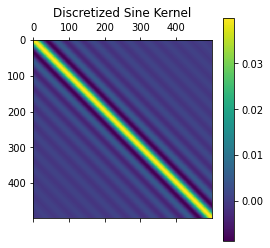

19


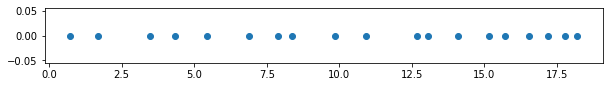

In [29]:
n = 500

#algorithm = "Poulson"
algorithm = "DPPy"

def Si(x):
    try: 
        upper = sici(x)[0]
    except:
        upper = sici(x)
    return upper
        
def integral_Si(x):
    return math.cos(x) + x*Si(x)

def compute_sine_kernel_entry(a,b,c,d):
    return (integral_Si(math.pi*(c-b))-integral_Si(math.pi*(c-a)) - (integral_Si(math.pi*(d-b))- integral_Si(math.pi*(d-a))))/((math.pi**2)*(b-a)*(d-c))

r =[0,20]
slice_size = (max(r)-min(r))/n

# determine # of slices 
n_slices = int((max(r)-min(r))/slice_size +1)

# split the range
x_part = np.linspace(*r, n_slices)
y_part = np.linspace(*r, n_slices)

kernel = np.array([[compute_sine_kernel_entry(x_part[i],x_part[i+1],y_part[j],y_part[j+1]) for i in range(len(x_part)-1)] for j in range(len(y_part)-1)])
kernel = kernel*(slice_size)


eigenvalues, eigenvectors = np.linalg.eig(kernel)

print("Kernel Trace: " + str(np.trace(kernel)))
print("Max Eigenvalue: " + str(max(eigenvalues.real)))
print("Min Eigenvalue: " + str(min(eigenvalues.real)))


samples = None

if algorithm == "Poulson":
    samples,_ = sampling_algorithm_1(kernel)
elif algorithm == "DPPy":
    DPP = FiniteDPP('correlation', **{'K': kernel})
    DPP.sample_exact()
    samples = DPP.list_of_samples[0]

plt.matshow(np.array(kernel))
plt.colorbar()
plt.title("Discretized Sine Kernel")
plt.show()

fig = plt.figure(figsize=(10,1))
plt.scatter(np.array(samples)/n*(max(r)-min(r)),np.zeros(len(samples)))
print(len(samples))

In [ ]:
n = 1000

#algorithm = "Poulson"
algorithm = "DPPy"

samples = 0

def compute_airy_kernel_entry(a,b,c,d):
    global samples 
    
    if (a==c):
        a+= 0.00000000001
    if (c==b):
        b-= 0.00000000001
        
    samples +=1 
    print(samples)
    clear_output(wait=True)
    
    return dblquad(lambda x, y: (airy(x)[0]*airy(y)[1] - airy(x)[1]*airy(y)[0])/(x-y), a,b,c,d)[0]

r =[-50,50]
slice_size = (max(r)-min(r))/n

# determine # of slices 
n_slices = int((max(r)-min(r))/slice_size +1)

# split the range
x_part = np.linspace(*r, n_slices)
y_part = np.linspace(*r, n_slices)

kernel = np.array([[compute_airy_kernel_entry(x_part[i],x_part[i+1],y_part[j],y_part[j+1]) for i in range(len(x_part)-1)] for j in range(len(y_part)-1)])
kernel = kernel*(slice_size)

print(np.min(kernel))

plt.matshow(np.array(kernel))

plt.colorbar()
plt.title("Discretized Airy Kernel")
plt.show()


eigenvalues, eigenvectors = np.linalg.eig(kernel)

print("Kernel Trace: " + str(np.trace(kernel)))
print("Max Eigenvalue: " + str(max(eigenvalues.real)))
print("Min Eigenvalue: " + str(min(eigenvalues.real)))


samples = None

if algorithm == "Poulson":
    samples,_ = sampling_algorithm_1(kernel)
elif algorithm == "DPPy":
    DPP = FiniteDPP('correlation', **{'K': kernel})
    DPP.sample_exact()
    samples = DPP.list_of_samples[0]


fig = plt.figure(figsize=(10,1))
plt.scatter(np.array(samples)/n*(max(r)-min(r)),np.zeros(len(samples)))
print(len(samples))

29142


In [ ]:
print(np.linalg.eig(kernel)[0])

In [ ]:
DPP = FiniteDPP('correlation',
                **{'K': kernel})
DPP.plot_kernel()



for _ in range(10):
    DPP.sample_exact()
    

DPP.list_of_samples
DPP.flush_samples()
DPP.list_of_samples

 # Scaled Sine Kernel Projection

In [ ]:
n = 100
a=0
b=100

bins = n-1

def sinx_x(m):
    m[m != 0] = np.sin(math.pi*m[m != 0])/(math.pi*m[m != 0])
    m[m==0] = 1
    return m 

partitions = np.linspace(a, b, num=n)

random_vect = np.array([np.random.uniform(partitions[i], partitions[i+1]) for i in range(len(partitions)-1)])
random_vect = np.repeat(random_vect, bins).reshape(bins,bins)

kernel = sinx_x(random_vect-random_vect.T)

#print(np.linalg.norm(kernel))

#kernel = kernel/(np.trace(kernel)) * 100


eigenvalues, eigenvectors = np.linalg.eig(kernel)

print(np.trace(kernel))
print(max(eigenvalues.real))


#print(eigenvalues.real)

#eigenvalues = eigenvalues.real

# Eigenvalue scaling
#eigenvalues /= max(eigenvalues)
#eigenvalues =  eigenvalues / sum(eigenvalues) * (b-a)

# Eigenvalue scaling 

#print(eigenvectors)
#/np.linalg.norm(kernel)

#print(np.trace(kernel_normalized))


#DPP = FiniteDPP('correlation',
#                **{'K': kernel_normalized})


#DPP = FiniteDPP('correlation',
#                **{'K_eig_dec': (eigenvalues.real, eigenvectors.real)})

#DPP.plot_kernel()
#for _ in range(1):
#    DPP.sample_exact()

#samples = DPP.list_of_samples[0]

#print(DPP.list_of_samples)

#kernel = eigenvectors.real.dot(np.diag(eigenvalues.real).dot(eigenvectors.real.T))


plt.matshow(np.array(kernel))
plt.colorbar()
plt.title("Discretized Sine Kernel")
plt.show()


#samples,A = sampling_algorithm_1(kernel)

fig = plt.figure(figsize=(10,1))
plt.scatter(samples,np.zeros(len(samples)))
print(samples)
#print(len(samples))

In [ ]:

print(np.linalg.eig(kernel_normalized)[0])

DPP = FiniteDPP('correlation',
                **{'K': kernel_normalized})
DPP.plot_kernel()

print(np.trace(kernel_normalized))

for _ in range(10):
    DPP.sample_exact()

DPP.list_of_samples


 # Gaussian Kernel in R^2


In [ ]:
n = 10
a=-1
b=1
intensity = 10 

bins = n-1

def gaussian_kernel(m):
    return np.exp(-(np.power(m,2)))

partitions = np.linspace(a, b, num=n)

random_vect = np.array([np.random.uniform(partitions[i], partitions[i+1]) for i in range(len(partitions)-1)])
random_vect = np.repeat(random_vect, bins).reshape(bins,bins)

kernel = gaussian_kernel(random_vect-random_vect.T)
kernel = kernel

print(np.trace(kernel))

plt.matshow(np.array(kernel))
plt.colorbar()
plt.title("Discretized Gaussian Kernel")
plt.show()

samples,_ = sampling_algorithm_1(np.array(kernel))
fig = plt.figure(figsize=(10,1))
plt.scatter(samples,np.zeros(len(samples)))
print(len(samples))

In [ ]:
bins_horizontal = 100
n = bins_horizontal * bins_horizontal
intensity = 5
a=0
b=5

partitions = np.linspace(a, b, num=bins_horizontal)

def gaussian_kernel_grid(m):
    return np.exp(-(np.power(m[:,:,0],2) + np.power(m[:,:,1],2)))

random_vect = np.array([[np.random.uniform(partitions[i], partitions[i+1]),
                         np.random.uniform(partitions[j], partitions[j+1]) ]
                       for i in range(len(partitions)-1) for j in range(len(partitions)-1)                        
                       ]
                      ).reshape(bins_horizontal-1,bins_horizontal-1,2)


kernel = gaussian_kernel_grid(random_vect-random_vect.transpose((1,0,2)))
kernel = (b-a)/np.trace(kernel) * kernel


plt.matshow(np.array(kernel))
plt.colorbar()
plt.title("Discretized Gaussian Kernel")
plt.show()

samples,_ = sampling_algorithm_1(np.array(kernel))


output = np.zeros(bins_horizontal)
output[samples] = 1

random_vect = np.array([[np.random.uniform(partitions[i], partitions[i+1]),
                         np.random.uniform(partitions[j], partitions[j+1]) ]
                       for i in range(bins_horizontal-1) for j in range(bins_horizontal-1)                        
                       ]
                      )


plt.scatter(random_vect[samples].T[0], random_vect[samples].T[1])
